# Practice Case 6 (Machine Learning)

### Arranged by : Rezki Hadiansah (Data Science Student)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.spatial.distance import cdist
from pathlib import Path
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#library for MBA
from mlxtend.frequent_patterns import apriori as ap
from mlxtend.frequent_patterns import association_rules

# Customer Segmentation and Market  Basket Analysis
![image](http://denary.wpengine.com/wp-content/uploads/2014/07/picture_market_segmentation-10-4-13-resized-600.png)
__Introduction__:
This notebook we using publicly dataset On-line Retail to explore customer segmentation through the interesting task  of unsupervised learning method. Then we go further and apply association rule mining approach to find interesting rules and patterns in this transaction database. These customer segmentation, rules and patterns can be used to make interesting and useful decisions as far as user interest is concerned. 

The [Online Retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail#) a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

But first, let's see some deep understand of both concepts:

* Customer segmentation: Customer segmentation is the problem of uncovering information about a firm's customer base, based on their interactions with the business. In most cases this interaction is in terms of their purchase behavior and patterns. We explore some of the ways in which this can be used.
* Market basket analysis: Market basket analysis is a method to gain insights into granular behavior of customers. This is helpful in devising strategies which uncovers deeper understanding of purchase decisions taken by the customers. This is interesting as a lot of times even the customer will be unaware of such biases or trends in their purchasing behavior.

## 1. Data Exploration (Data Understanding)

In [2]:
#Read the data
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#See data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#See Statistic of Data
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 2. Preprocessing

From data exploration, we can see there are 2 variables that contain missing value, "Customer ID" and "Description".

1. Customer ID

In [7]:
df['CustomerID'].value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [8]:
missing_values = df.isnull().sum()
percent_missing = df.isnull().sum() / len(df) * 100

#create dataframe
missing_table = pd.concat([missing_values, percent_missing],axis=1).reset_index()

#rename columns
missing_table = missing_table.rename(columns={'index':'name column', 0:'total missing', 1:'percent missing'})
missing_table['percent missing'] = round(missing_table['percent missing'],1)

#sort values
missing_table = missing_table.sort_values('percent missing', ascending=False)

missing_table

,name column,total missing,percent missing
6,CustomerID,135080,24.9
2,Description,1454,0.3
0,InvoiceNo,0,0.0
1,StockCode,0,0.0
3,Quantity,0,0.0
4,InvoiceDate,0,0.0
5,UnitPrice,0,0.0
7,Country,0,0.0


#### From here, we can see CustomerID isn't unique in every data. So, the data is the sale of every product from one customer, then we can't impute with random value.  Because we will do Customer Segmentation based on Customer ID, I will choose to drop the Missing Value and all row based from customer ID.

In [9]:
df_clean1= df[pd.notnull(df['CustomerID'])]

df_clean1.shape

(406829, 8)

2. Next we will handle Description, I will drop the all row in 'Description' Missing Value

In [10]:
df_clean2 = df_clean1.dropna(subset=['Description'])

In [11]:
df_clean2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
df_clean2.shape 

(406829, 8)

From line 7 (df.describe()), we can see that there are some data who has negative value of **Quantity** and negative value of **Unit Price**. So, I will drop them.

3. Drop negative value on variable Feature **Quantity** and **Unit Price**

In [13]:
#For Quantity
indexQ=df_clean2[df_clean2['Quantity']<0].index
df_clean2.drop(indexQ,inplace=True)
#For UnitPrice
indexU=df_clean2[df_clean2['UnitPrice']<0].index
df_clean2.drop(indexU,inplace=True)

In [14]:
df_clean2.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


4. Create New Feature: TotalPrice (UnitPrice * Quantity)

In [15]:
df_clean2['TotalPrice'] = df_clean2['UnitPrice'] * df_clean2['Quantity']

In [16]:
df_clean2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


5. Create New Feature for Date: Day, Month, Year

In [17]:
df_clean2['year'] = df_clean2.InvoiceDate.dt.year
df_clean2['yearmonth'] = df_clean2['InvoiceDate'].map(lambda x: 100*x.year + x.month)
df_clean2['month'] = df_clean2.InvoiceDate.dt.month
df_clean2['day'] = df_clean2.InvoiceDate.dt.dayofweek + 1
#Replace 7=Sunday as 6=Sunday
df_clean2['day']=df_clean2['day'].replace(7,6)
#1=Monday, 2=Tuesday,...,7=Sunday
df_clean2['hour'] = df_clean2.InvoiceDate.dt.hour

In [18]:
df_clean2.day.value_counts()

4    80052
3    68888
2    66476
1    64899
6    62775
5    54834
Name: day, dtype: int64

After Pre-processing we have:

In [19]:
print('Total {} data with {} features'.format(df_clean2.shape[0],df_clean2.shape[1]))

Total 397924 data with 14 features


In [20]:
df_clean2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,year,yearmonth,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,201012,12,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,201012,12,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,201012,12,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,201012,12,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,201012,12,3,8


#### Now we have no Problems in the data. The next step is analyzing the data (Exploratory Data Analysis)

## 3. EDA

There will be several Question in this analysis. There are:
#### 1. Who is customer that spend most of money?

In [21]:
df_clean2.sort_values('TotalPrice', ascending=False).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,year,yearmonth,month,day,hour
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60,2011,201112,12,5,9
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60,2011,201101,1,2,10
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00,2011,201106,6,5,15
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75,2011,201105,5,2,13
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72,2011,201109,9,2,11


We can see that Customer with ID 16446 is the Customer who spend most of money  from United Kingdom with with **Total Price 168,469$**

#### 2. Which customer has the highest quantity of buying

In [22]:
df_clean2.sort_values('Quantity', ascending=False).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,year,yearmonth,month,day,hour
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6,2011,201112,12,5,9
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011,201101,1,2,10
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,0.0,2011,201111,11,5,15
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,1008.0,2011,201110,10,4,12
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,3096.0,2011,201105,5,5,10


We can see that Customer with ID 16446 is the Customer who spend most of money  from United Kingdom with with **Quantity 80995**

**Conclusion**:
From two question above, we can see the same Customer as the highest total amount price and total quantity. It's make sense./

#### 3. Which day with most of transaction occured??

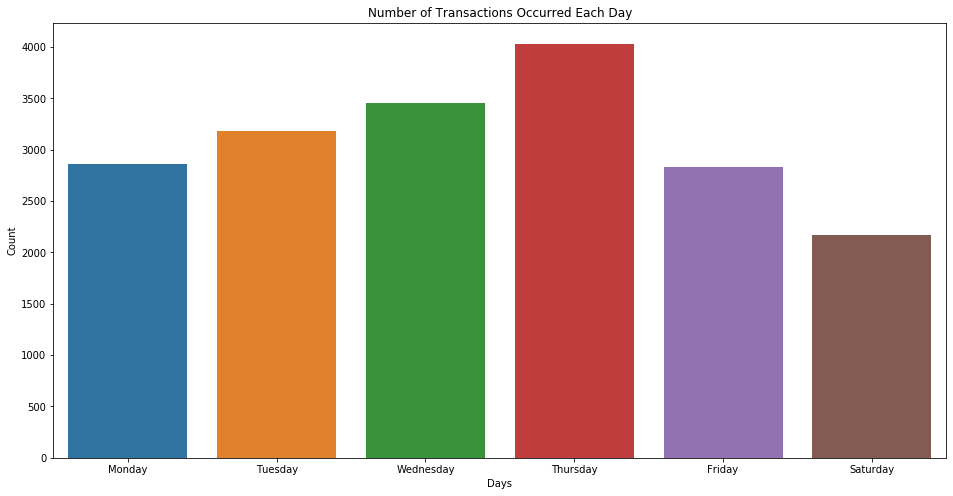

In [23]:
ans3 = df_clean2.groupby(df_clean2.day)['InvoiceNo'].nunique()

fig,ax=plt.subplots(figsize=(16,8))

ax = sns.barplot(x = ans3.index, y =ans3.values).set(title='Number of Transactions Occurred Each Day',xlabel='Days',ylabel='Count')
ax = plt.xticks(ans3.index-1,['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

**Conclusion**:

1. Thursday was the busiest day.
2. In other hand, Saturday was the day with the lowest number of transaction.

#### 4. Which Month with most of transaction occured??

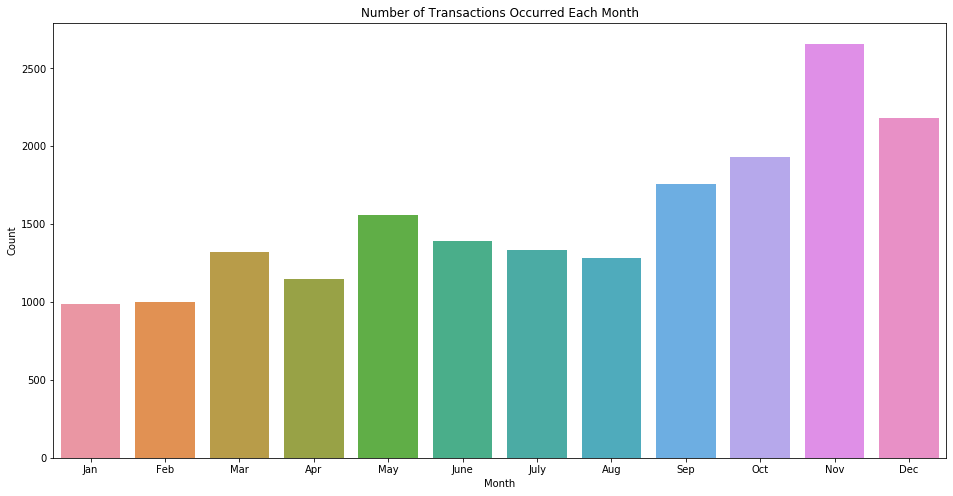

In [24]:
ans4 = df_clean2.groupby(df_clean2.InvoiceDate.dt.month)['InvoiceNo'].nunique()

fig,ax=plt.subplots(figsize=(16,8))

ax = sns.barplot(x = ans4.index, y =ans4.values).set(title='Number of Transactions Occurred Each Month',xlabel='Month',ylabel='Count')
ax = plt.xticks(ans4.index-1,['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'])

**Conclusion**:
1. From line chart above, we can see November was the busiest month. I think it's make sense, retrace that November was the month near holiday.
2. We can see, after November, the total transaction become lower until February

#### 5. Which hour with most total transaction??

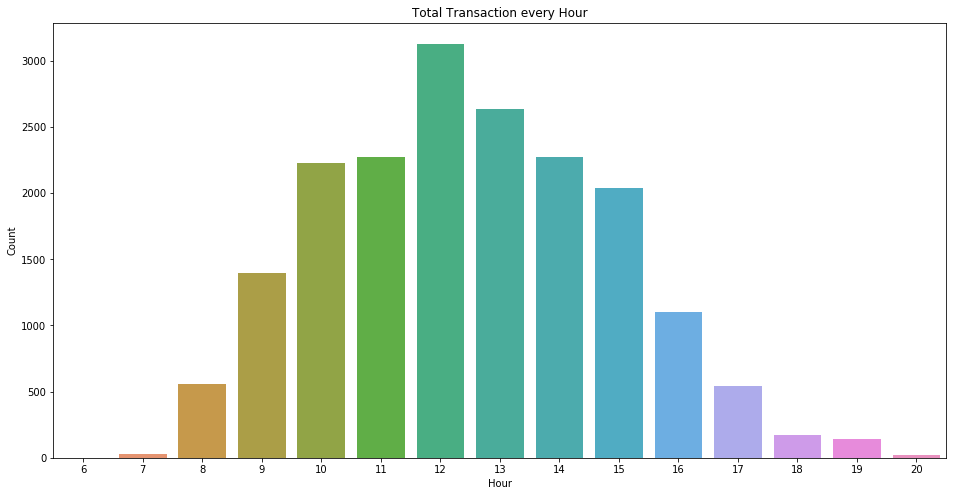

In [25]:
ans5 = df_clean2.groupby(df_clean2.hour)['InvoiceNo'].nunique()

fig,ax=plt.subplots(figsize=(16,8))

ax = sns.barplot(x = ans5.index, y =ans5.values).set(title='Total Transaction every Hour',xlabel='Hour',ylabel='Count')

**Conclusion**:
1. Most busiest hour is in 12, which mean around 12AM to 1PM
2. The distribution is most likely in normal distributon

#### 6. How the trend of transaction every month in years??

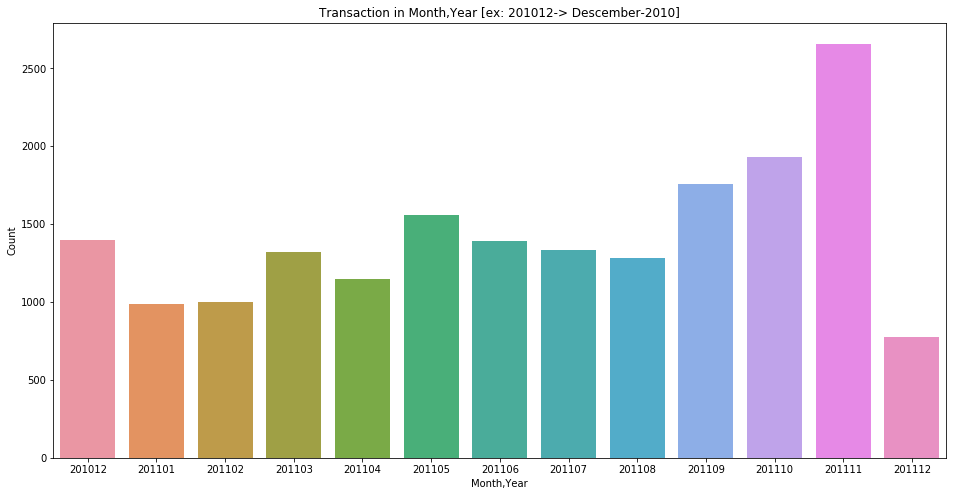

In [26]:
ans6 = df_clean2.groupby(df_clean2.yearmonth)['InvoiceNo'].nunique()

fig,ax=plt.subplots(figsize=(16,8))

ax = sns.barplot(x = ans6.index, y =ans6.values).set(title='Transaction in Month,Year [ex: 201012-> Descember-2010]',xlabel='Month,Year',ylabel='Count')

**Conclusion**:
1. November,2011 was the month with highest transaction.

# 4. Customer Segmentation: Country-based

In this problem, I will try to do Segmentation based on Country (Geographical Segmentation). 

I'll see how many customers from another country. The reason is because the customer from this retail is from many country in the world.


### 4a. See Customer Spread of Country from UK and Other Country

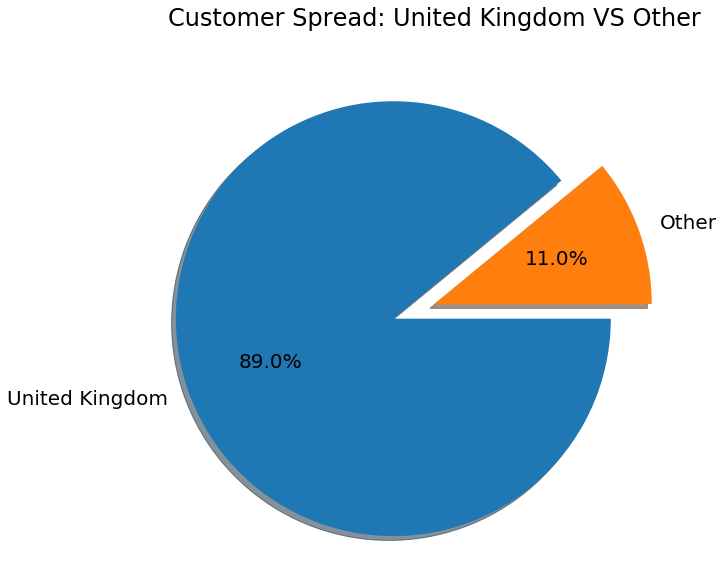

In [27]:
country_count = df_clean2[['Country']]
country_count['Country'] = country_count.Country.apply(lambda x: 'Other' if x != 'United Kingdom' else x)
country_count = country_count.groupby('Country').size().reset_index().sort_values(0,ascending=False).rename(columns={0:'Count'})

plt.rcParams['font.size'] = 20
plt.figure(figsize=(20,10))
plt.pie(country_count.Count, autopct='%1.1f%%', labels=country_count.Country,
counterclock=False, shadow=True, explode=(0.2,0))

plt.title('Customer Spread: United Kingdom VS Other')
plt.show()

**Conclusion**:


About 11% (or 43,579 Customers) are come from Other Country and 89% (or 354,345 Customers) are from UK.

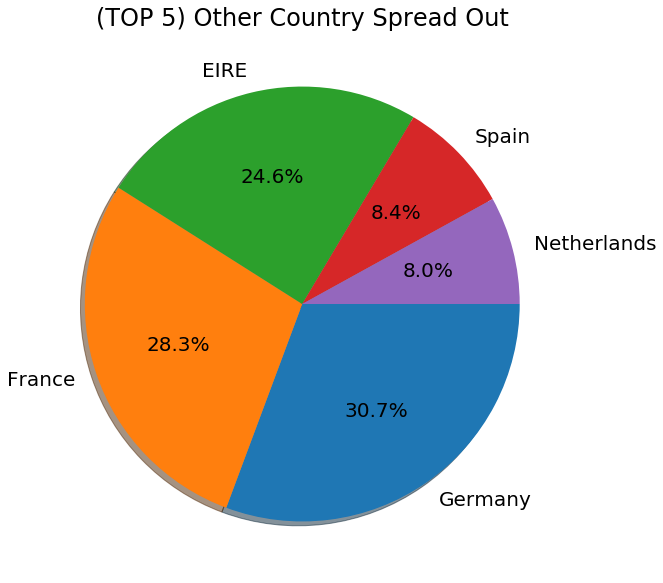

In [28]:
Other = df_clean2[df_clean2.Country != 'United Kingdom']
Other = Other.groupby('Country').size().reset_index().sort_values(0,ascending=False).rename(columns={0:'Count'})

plt.rcParams['font.size'] = 20
plt.figure(figsize=(20,10))
plt.pie(Other.Count[:5], autopct='%1.1f%%', labels=Other.Country[:5],
counterclock=False, shadow=True)

plt.title('(TOP 5) Other Country Spread Out')
plt.show()

**Conclusion**:

**France** and **Germany** were the other Countries who often go to the retail. It's make sense because that two countries are near to UK.

## **Customer Behavior Based Segmentation**

<img src='https://40uu5c99f3a2ja7s7miveqgqu-wpengine.netdna-ssl.com/wp-content/uploads/2015/04/Customer-lifetime-value-and-good-old-RFM-via-Sociomantic.gif'>

For customer behavior segmentation, I used RFM analysis.

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a **RFM**,***Recency, Frequency and Monetary Value**, based model of customer value for finding our customer segments.
 The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

Theoretically we will have segments like below:

1. Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

2. Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

3. High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

#### Lets see the final data after pre-processing:

In [29]:
df_clean2.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice,year,yearmonth,month,day,hour
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749,2010.934259,201101.038417,7.612537,3.456798,12.728247
std,180.420210,22.096788,1713.169877,309.055588,0.247829,23.836517,3.416527,1.668219,2.273535
min,1.000000,0.000000,12346.000000,0.000000,2010.000000,201012.000000,1.000000,1.000000,6.000000
25%,2.000000,1.250000,13969.000000,4.680000,2011.000000,201104.000000,5.000000,2.000000,11.000000
50%,6.000000,1.950000,15159.000000,11.800000,2011.000000,201107.000000,8.000000,3.000000,13.000000
75%,12.000000,3.750000,16795.000000,19.800000,2011.000000,201110.000000,11.000000,5.000000,14.000000
max,80995.000000,8142.750000,18287.000000,168469.600000,2011.000000,201112.000000,12.000000,6.000000,20.000000


### 1. Recency (in days)

In [30]:
recency = pd.DataFrame(df_clean2.CustomerID).merge(pd.DataFrame((df_clean2.InvoiceDate.max()-df_clean2.InvoiceDate).dt.days).rename(columns={'InvoiceDate':'last_shop'}), left_index=True, right_index=True)
recency = pd.DataFrame(recency.groupby('CustomerID')['last_shop'].min()).reset_index()
recency['last_shop']=recency['last_shop']+1
recency.sort_values('CustomerID')
recency=recency.rename(columns={'last_shop':'Recency'})
recency.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


### 3. Frequency (Shopping Count)

In [31]:
count_shop=df_clean2.groupby(['CustomerID'])['InvoiceNo'].aggregate('count').reset_index()
frequency=count_shop.rename(columns={'InvoiceNo': 'Frequency'})
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### 3. Monetary (Total Shopping)

In [32]:
monetary=df_clean2.groupby(['CustomerID'])['TotalPrice'].aggregate('sum').reset_index()
monetary=monetary.rename(columns={'TotalPrice':'Monetary'})
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


So, we got the RFM data set like this:

### 4. Recency, Frequency, & Monetary (RFM Dataset)

In [33]:
rfm = recency.merge(frequency, on='CustomerID')
rfm = rfm.merge(monetary, on='CustomerID')

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


### 5. Visualization of RFM Dataset

#### A. Recency

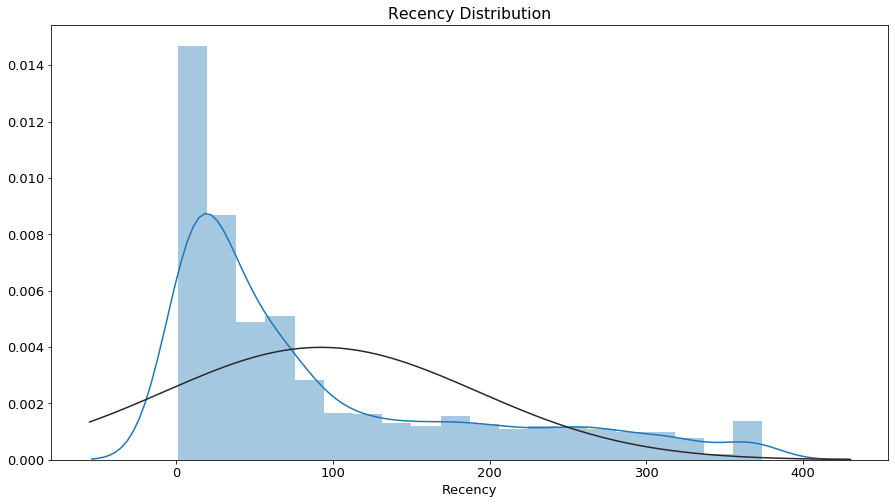

From Recency data, we got 1.2463568823921842 skew value


In [34]:
#check skewness
r_skew = rfm['Recency'].skew()

plt.rcParams['font.size']=13
plt.figure(figsize=(15,8))
sns.distplot(rfm['Recency'],fit=norm,bins=20)
plt.title('Recency Distribution')

plt.show()
print('From Recency data, we got {} skew value'.format(r_skew))


#### B. Frequency

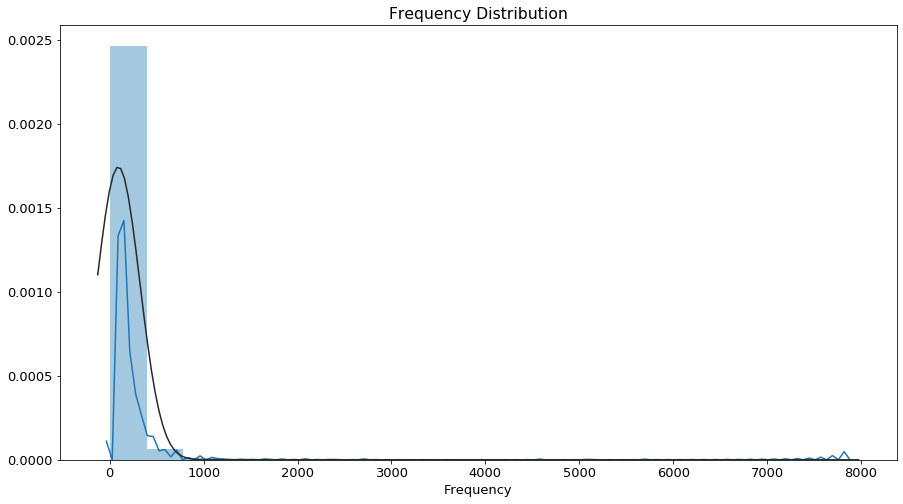

From Frequency data, we got 18.106242903118684 skew value


In [35]:
#check skewness
f_skew = rfm['Frequency'].skew()

plt.rcParams['font.size']=13
plt.figure(figsize=(15,8))
sns.distplot(rfm['Frequency'],fit=norm,bins=20)
plt.title('Frequency Distribution')


plt.show()
print('From Frequency data, we got {} skew value'.format(f_skew))


#### C. Monetary

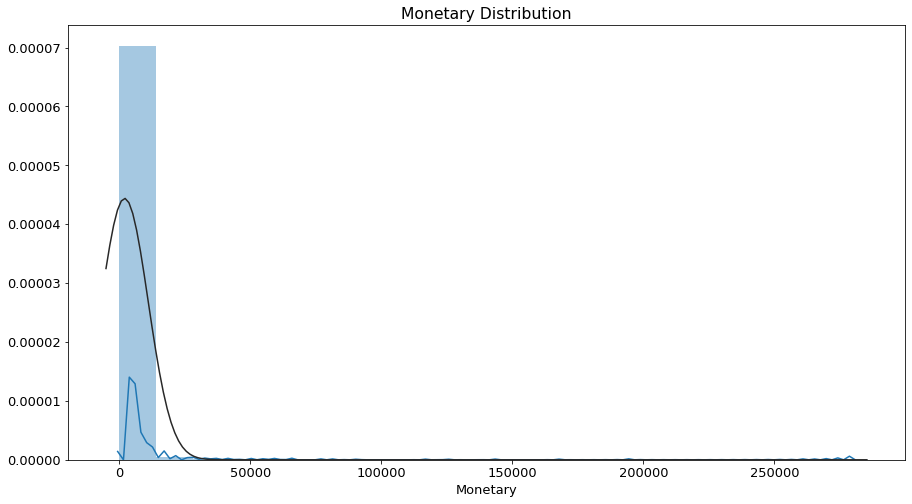

From Monetary data, we got 19.326985305561827 skew value


In [36]:
#check skewness
m_skew = rfm['Monetary'].skew()

plt.rcParams['font.size']=13
plt.figure(figsize=(15,8))
sns.distplot(rfm['Monetary'],fit=norm,bins=20)
plt.title('Monetary Distribution')
plt.show()
print('From Monetary data, we got {} skew value'.format(m_skew))


### Data Transformation

In [37]:
print('These three plots are too positive-skewed')
print('\nRecency   : {}'.format(r_skew),
     '\nFrequency : {}'.format(f_skew),
     '\nMonetary  : {}'.format(m_skew))

These three plots are too positive-skewed

Recency   : 1.2463568823921842 
Frequency : 18.106242903118684 
Monetary  : 19.326985305561827


We will do Data transformation on Data RFM to make them similar to Normal Distribution.

1. Transform the data set

In [38]:
norm_rfm = rfm.copy()
norm_rfm = norm_rfm.drop('CustomerID',axis=1)


power = PowerTransformer().fit(norm_rfm)
rfm_scaled =power.transform(norm_rfm)

#Standard Scaler to Scale the data
scaler = StandardScaler().fit(rfm_scaled)
rfm_scaled = scaler.transform(rfm_scaled)

2. Recency (Scaled)

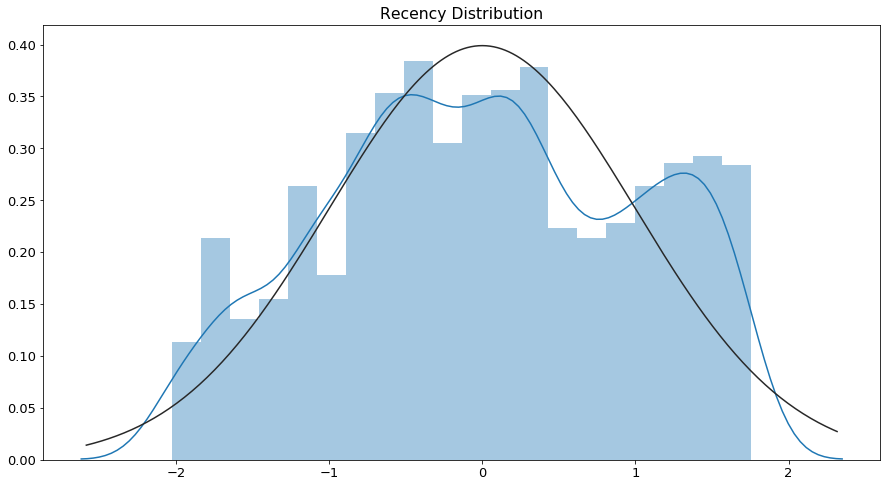

From Recency data, we got -0.05647257062038645 skew value


In [39]:
scale_r_skew = skew(rfm_scaled)[0]

plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,0],fit=norm,bins=20)
plt.title('Recency Distribution')
plt.show()
print('From Recency data, we got {} skew value'.format(scale_r_skew))


3. Frequency (Scaled)

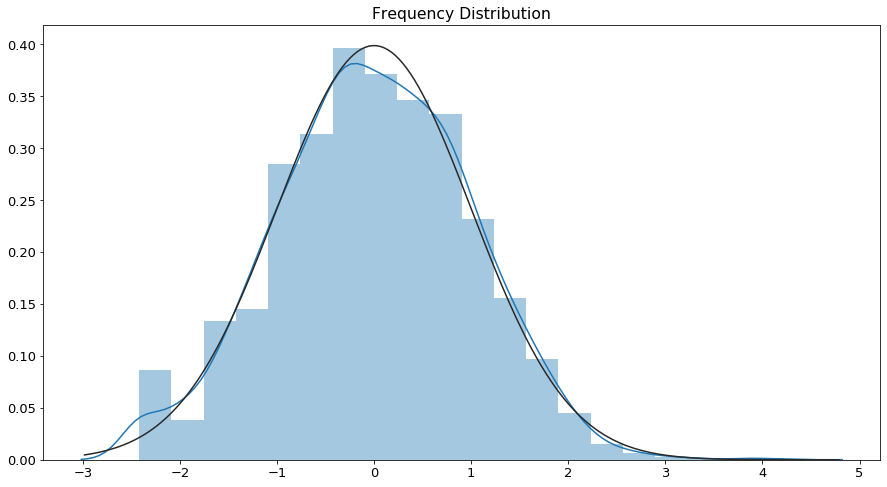

From Frequency data, we got -0.00010273449187216635 skew value


In [40]:
#check skewness
scale_f_skew = skew(rfm_scaled)[1]

plt.rcParams['font.size']=13
plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,1],fit=norm,bins=20)
plt.title('Frequency Distribution')


plt.show()
print('From Frequency data, we got {} skew value'.format(scale_f_skew))


4. Monetary (Scaled)

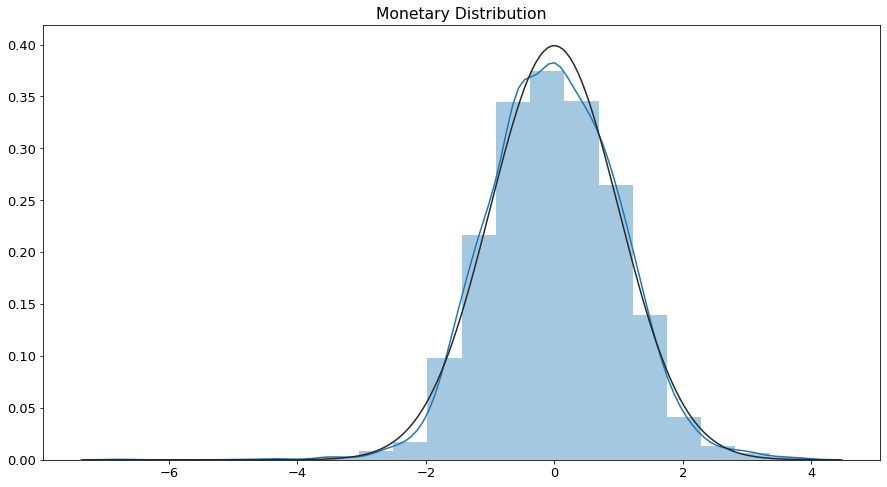

From Monetary data, we got -0.022745470391299323 skew value


In [41]:
#check skewness
scale_m_skew = skew(rfm_scaled)[2]

plt.rcParams['font.size']=13
plt.figure(figsize=(15,8))
sns.distplot(rfm_scaled[:,2],fit=norm,bins=20)
plt.title('Monetary Distribution')

plt.show()
print('From Monetary data, we got {} skew value'.format(scale_m_skew))

##### From here, we can see all three plots Recency, Frequency, and Monetary have skewness close to 0. 

##### Now we can Assume That the RFM (Scaled) data in normal distribution

# 5. Clustering with K-Means

## 1. Elbow Method

Elbow Method is used to find the best number of cluster by looking the "Elbow" from Inertia chart to number of clusters. **Where** Inertia is sum squared of distance from samples to their closests centroid.

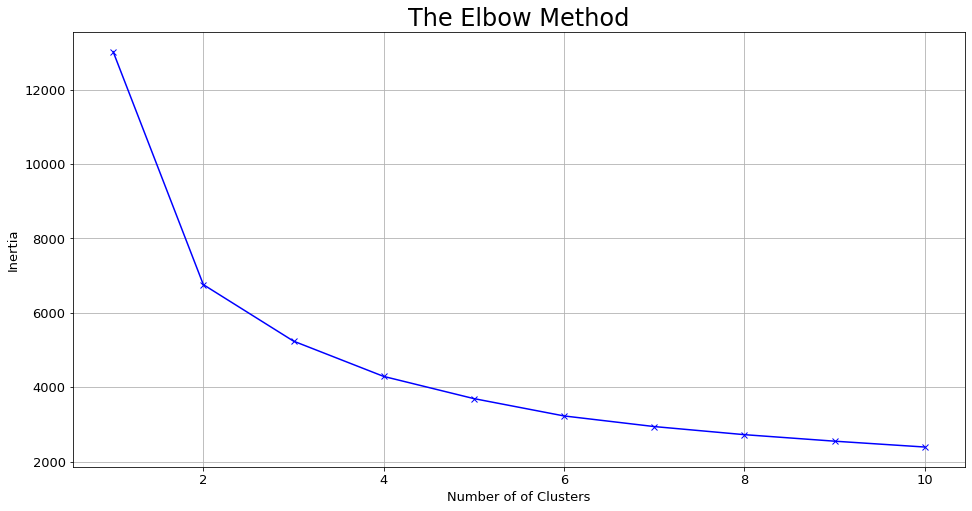

In [42]:
from sklearn.cluster import KMeans
inertia=[]
cl = 10

for i in range(1,cl+1):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


fig,ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.rcParams['font.size']=20
plt.plot(range(1,cl+1), inertia, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [43]:
for i in range(len(inertia)):
    print('The Inertia Value for {} Clusters is {}'.format(i+1,round(inertia[i],2)))

The Inertia Value for 1 Clusters is 13017.0
The Inertia Value for 2 Clusters is 6754.97
The Inertia Value for 3 Clusters is 5236.33
The Inertia Value for 4 Clusters is 4287.46
The Inertia Value for 5 Clusters is 3691.09
The Inertia Value for 6 Clusters is 3225.14
The Inertia Value for 7 Clusters is 2939.62
The Inertia Value for 8 Clusters is 2721.88
The Inertia Value for 9 Clusters is 2546.77
The Inertia Value for 10 Clusters is 2389.44


In [44]:
for i in range(len(inertia)-1):
    inertia[i]=round(inertia[i],2)
    decrease= (inertia[i]-inertia[i+1])/inertia[i]
    percent_decrease= round(decrease*100,2)
    print('Inertia decrease from {} Cluster to {} Cluster is {} %'
         .format(i+1,i+2, percent_decrease))

Inertia decrease from 1 Cluster to 2 Cluster is 48.11 %
Inertia decrease from 2 Cluster to 3 Cluster is 22.48 %
Inertia decrease from 3 Cluster to 4 Cluster is 18.12 %
Inertia decrease from 4 Cluster to 5 Cluster is 13.91 %
Inertia decrease from 5 Cluster to 6 Cluster is 12.62 %
Inertia decrease from 6 Cluster to 7 Cluster is 8.85 %
Inertia decrease from 7 Cluster to 8 Cluster is 7.41 %
Inertia decrease from 8 Cluster to 9 Cluster is 6.43 %
Inertia decrease from 9 Cluster to 10 Cluster is 6.18 %


#### As we can see from the Elbow chart, we can conclude that the highest change was happend between 4 Clusters, 5 Clusters, and 6 Clusters.

(Note: See where clusters when the line plot start to change constantly)

## 2. Shihoutte Analysis

One of the candidate number of clusters from Elbow method will be selected. To do that, I use Shihoutte Analysis based on shihoutte value.

For n_clusters = 2 The average silhouette_score is : 0.396689892885645


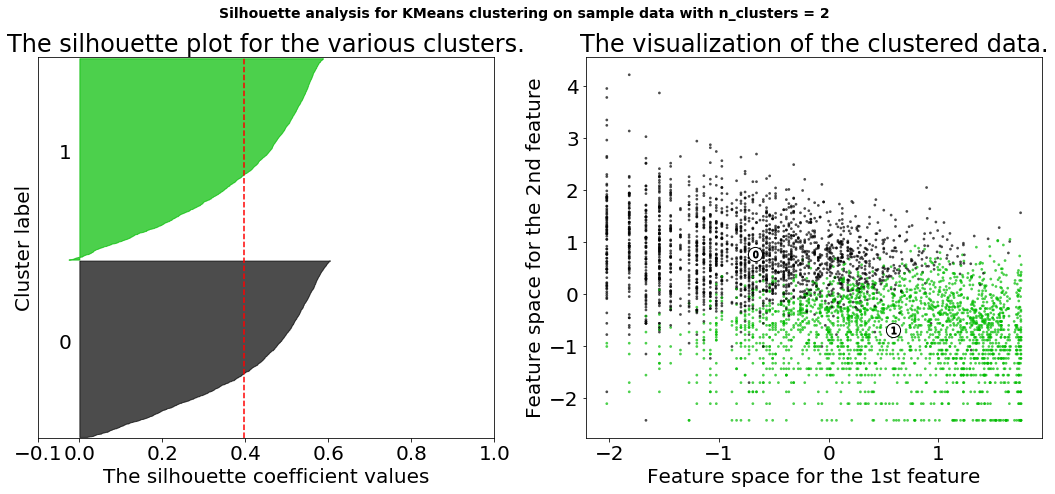

For n_clusters = 3 The average silhouette_score is : 0.29952912686846084


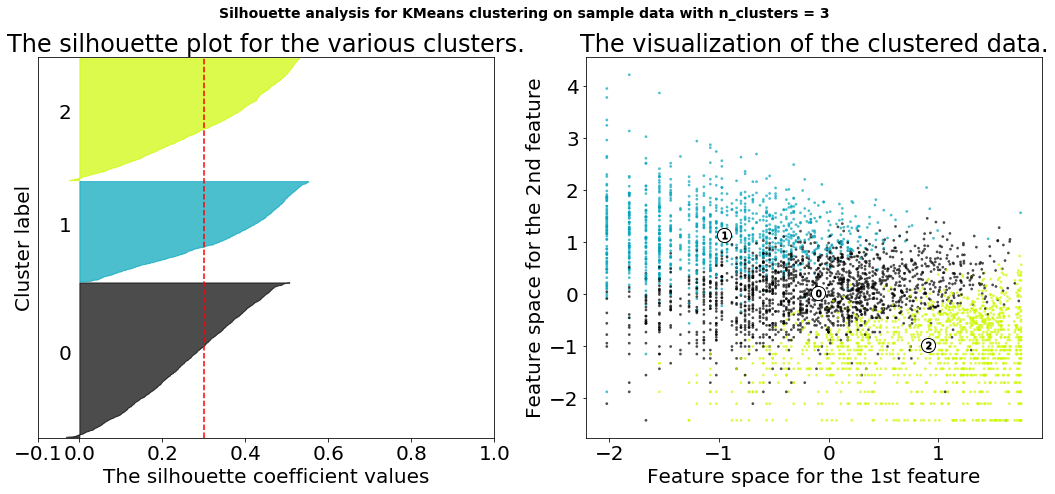

For n_clusters = 4 The average silhouette_score is : 0.3044718924350109


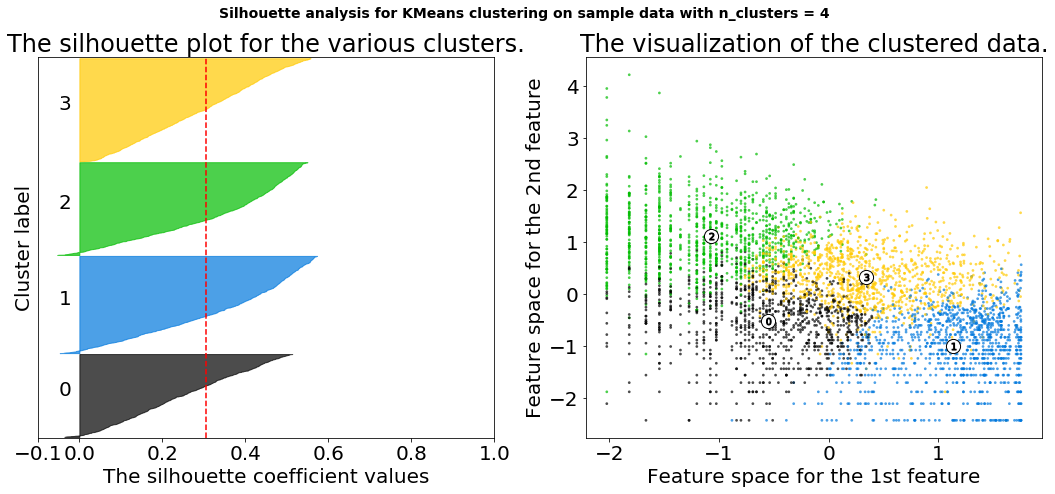

For n_clusters = 5 The average silhouette_score is : 0.27731263762955316


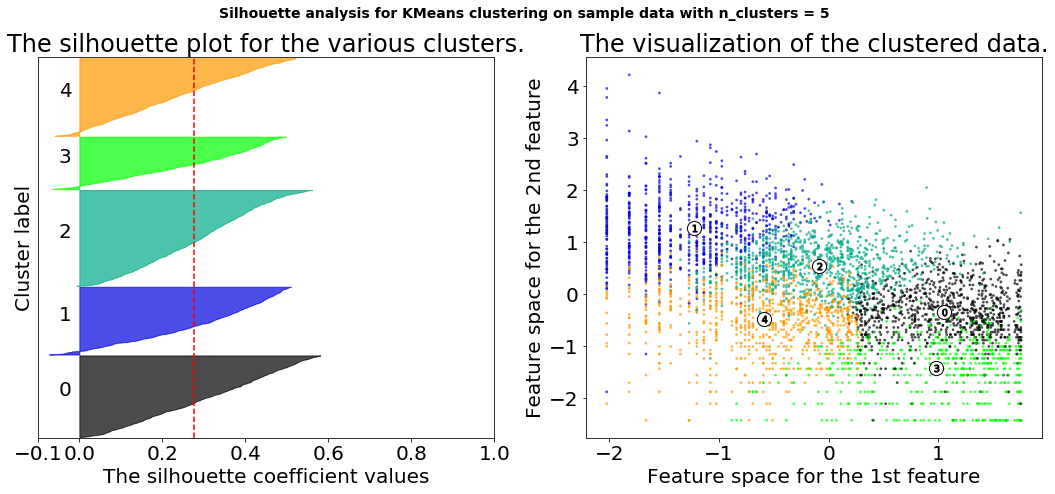

For n_clusters = 6 The average silhouette_score is : 0.277072376550618


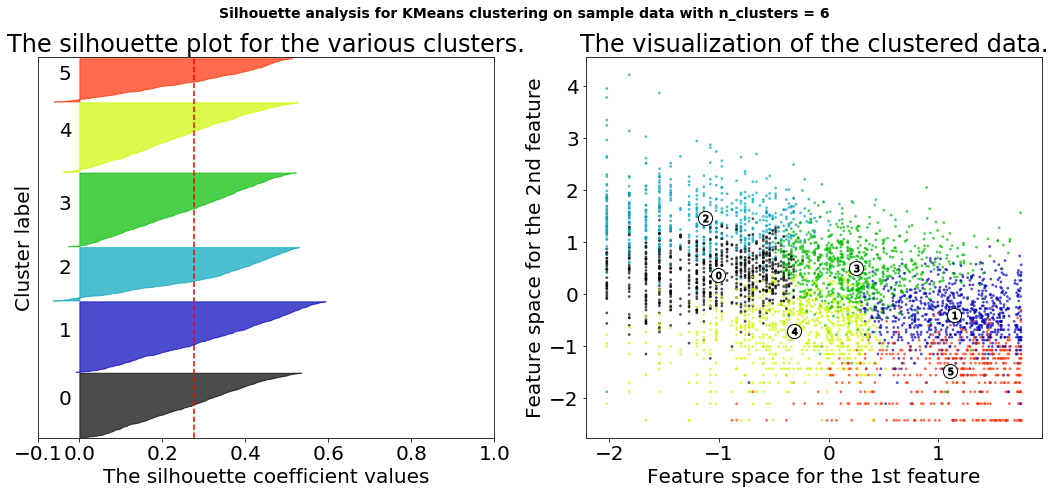

In [45]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_scaled[:, 0], rfm_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

**Conclusion:**
1. All Cluster are valid to be Choosen. (You can see if the red line cross all Sihouette clusters, the Cluster are valid)
2. The condition is we choose the Cluster who have the highest verage silhouette_score
3. There are two candidate: 2 Clusters with 0.39 silhouette_score and 4 Clusters with 0.30
4. Even if 2 Clusters have higher score than 4 Clusters, I prefer choose 4 Clusters. The result is based on The Elbow method. 4 Clusters is the candiate on Elbow method


### Final Result: 4 Clusters

## 3. Analysis of Clustering with 4 Clusters (K-Means Method)

In [46]:
n = 4

model = KMeans(n_clusters=n,init='k-means++',max_iter=300, n_init=10, random_state=0)

#fit the data
model_kmeans = model.fit(rfm_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model_kmeans.labels_

centers = model_kmeans.cluster_centers_

In [47]:
#Append labels/clusters to scaled and original dataframe
rfm['cluster'] = labels
clusters_seg = pd.DataFrame(rfm_scaled,columns=['Recency','Frequency','Monetary'])
clusters_seg['Cluster'] = labels+1

Let's see the center and clusters' description

In [48]:
clusters = []

for i in range(0,n):
    clusters.append(rfm[rfm.cluster==i])

values = power.inverse_transform(scaler.inverse_transform(centers))

for i in range(0,n):
    print('-----CLUSTER {}-----'.format(i+1))
    print('Number of Customers: {}'.format(clusters[i].shape[0]))
    print('(Recency)Total purchases: £{:6.2f}'.format(values[i][2]))
    print('(Frec)Purchases Frequency : {:4.0f}'.format(values[i][1]))
    print('(Monetary)Last Day Shopping: {:4.0f}\n'.format(values[i][0]))

-----CLUSTER 1-----
Number of Customers: 957
(Recency)Total purchases: £351.52
(Frec)Purchases Frequency :   21
(Monetary)Last Day Shopping:   24

-----CLUSTER 2-----
Number of Customers: 1122
(Recency)Total purchases: £218.21
(Frec)Purchases Frequency :   11
(Monetary)Last Day Shopping:  197

-----CLUSTER 3-----
Number of Customers: 1071
(Recency)Total purchases: £2957.32
(Frec)Purchases Frequency :  171
(Monetary)Last Day Shopping:   10

-----CLUSTER 4-----
Number of Customers: 1189
(Recency)Total purchases: £1065.84
(Frec)Purchases Frequency :   62
(Monetary)Last Day Shopping:   79



## 4. Conclusion

1. **Cluster 3** is our **Champion Cluster** with the highest total purchases, purchases Frequency and the smallest Last day shopping. We don't need give special offer, we can just give notification about recommended item based on what they bought before.
2. **Cluster 4** is **Middle cluster** with second highest total purchases and frequency. we also find that the cluster has wide-range last day shopping (79).  for this cluster, we can give them special offer depends on their purchase history to make them shopping more often.
3. **Cluster 2** is **Risky Cluster** because they has smaller total purchases and frequency than cluster 4, but has smaller 'last day shopping' than cluster 4, we can conclude that the customers in cluster 3 are regular customers but always buy cheapest items or only buy some items. We can give them some offer like "Buy this + this got discount" so they maybe will buy the item more than before.
4. **Cluster 1** is **Warning Cluster** because they has smallest total purchases and frequency, also highest 'last day shopping' among all clusters. we need different strategy for this cluster like giving voucher or gives some special offer.

# 5. Market Basket Analysis

![alt text](https://miro.medium.com/max/2560/1*2uSqS4cTYNXylx5a16OjHw.png)


Market Basket Analysis is a technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence. A co-occurrence is when two or more things take place together. One of the methods is called **association-rules**.<br>

<br> Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain's feature extraction and abstract association capabilities from new uncategorized data.<br>

<br>Association rules are normally written like this: **{Diapers} -> {Beer}** which means that there is a strong relationship between customers that purchased diapers and also purchased beer in the same transaction.

In the above example, the {Diaper} is the **antecedent** and the {Beer} is the **consequent**. Both antecedents and consequents can have multiple items. In other words, {Diaper, Gum} -> {Beer, Chips} is a valid rule.

There're some terminology in association-rules:

>**Support** It is a measure of how frequently the collection of items occur together as a percentage of all transactions.<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1c6acacd3b17051205704b5d323c83fc737e5db1" style="left:50%">

>**Confidence** is interpreted as: How often items in B appear in transactions that contain A only. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/90324dedc399441696116eed3658fd17c5da4329" style="left:50%">


>**Lift** The Lift tells us how much better a rule is at predicting the result than just assuming the result in the first place. Greater lift values indicate stronger associations. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.
<br><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c392e3111167b60687405dfdc7ed55f22409f4c5" style="left:50%">


## Market Basket Analysis in General

In [49]:
# Dummy conding and creation of the baskets_sets, 
#indexed by InvoiceNo with 1 corresponding to every item presented on the basket

basket = df_clean2.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

def is_one(data):
  if data <= 0 :
    return 0
  else:
    return 1
basket = basket.applymap(is_one)

basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Apriori aplication: frequent_itemsets
frequent_item = ap(basket, min_support=0.025, use_colnames=True)
frequent_item['length'] = frequent_item['itemsets'].apply(lambda x: len(x))

# Advanced and strategical data frequent set selection
frequent_item.head()

,support,itemsets,length
0,0.039167,(6 RIBBONS RUSTIC CHARM),1
1,0.025140,(60 CAKE CASES VINTAGE CHRISTMAS),1
2,0.035445,(60 TEATIME FAIRY CAKE CASES),1
3,0.027028,(72 SWEETHEART FAIRY CAKE CASES),1
4,0.042566,(ALARM CLOCK BAKELIKE GREEN),1


In [51]:
# Generating the association_rules: rules
# Selecting the important parameters for analysis
rules = association_rules(frequent_item, metric="lift", min_threshold=1)
rules.sort_values('support', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.086319,0.046990,0.029456,0.341250,7.262239,0.025400,1.446695
5,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.046990,0.086319,0.029456,0.626866,7.262239,0.025400,2.448666
2,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042242,0.037279,0.029186,0.690932,18.534184,0.027612,3.114920
3,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037279,0.042242,0.029186,0.782923,18.534184,0.027612,4.412071
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042566,0.047313,0.028593,0.671736,14.197612,0.026579,2.902200
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047313,0.042566,0.028593,0.604333,14.197612,0.026579,2.419798
10,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.069486,0.050227,0.028215,0.406056,8.084481,0.024725,1.599096
11,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.050227,0.069486,0.028215,0.561762,8.084481,0.024725,2.123304
8,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.069486,0.056754,0.027892,0.401398,7.072533,0.023948,1.575746
9,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.056754,0.069486,0.027892,0.491445,7.072533,0.023948,1.829720


### Conclusion

From MBA above we got insight that Item: Jumbo Bag has bigest confindence value and most of antecendents. On the Consequents, we can see that Bag is relatively will be bought but in other color. One strategi that we can try is Give more variant of colour items for Jumbo Bag with unique design. 


NP: It seem people like buy more than one bag even if it's the same bag. So I think the buyer was Parent who bought bag for her/his twin child (or similar).